# Lecture 16: Heterodyne Design Tradeoffs

EE-40453, Digital Radio Communications, Spring 2020

J. Nicholas Laneman, Bertrand Hochwald, & Jonathan Chisum<br>
Wireless Institute & Department of Electrical Engineering<br>
University of Notre Dame

Copyright 2020, All Rights Reserved

## Summary

In this lecture, we will put all the pieces together and experiment numerically with various design tradeoffs for heterodyne transmitter and receiver design.

## Outline

* System Block Diagram

* Numerical Explorations

## System Block Diagram

<img src="images/01.png" width="80%">

### Key Parameters

* Bit / symbol rate $R$

* $9x\%$-bandwidth $B$ of the baseband signal $m(t)$

* Largest IF frequency $f_i$ that can be handled by the first stage of upconversion and last stage of downconversion, especially limited sampling frequency and / or bandwidth of the DACs and ADCs

* Passbands, transition bands, and stopband attenuations of the RF and IF bandpass filters as well as BB lowpass filter.

### Filter Design

To model the tradeoffs associated with practical filters, it makes sense to focus on one or two classes of filter designs. The most common filter classes include Butterworth, Chebyshev Types 1 and 2, and Elliptical filters. These filter types are illustrated in the figure below, for the case of lowpass filters of order five.

<img src="images/1000px-Filters_order5.svg.png" width="80%">
(Image from: https://en.wikipedia.org/wiki/Butterworth_filter)


Based upon the above examples, we recommend use of the Butterworth or Chebyshev Type 2 filters. The Butterworth filters are maximally in the passband and exhibit no ripple in the stopband. Chebyshev Type 2 have a narrower transition band but exhibit ripple in the stopband.

Note: The Python package SciPy has filter design and filtering routines for Butterworth, Chebyshev, and Elliptical filters.

https://docs.scipy.org/doc/scipy-0.14.0/reference/signal.html

## Numerical Explorations

In [1]:
# Allows interactive plots inside Jupyter Notebooks!!

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import upfirdn, butter, cheby2, lfilter, hilbert

System parameters

In [2]:
fc = 2.4e9 # target carrier frequency
fi = 15e6 # intermediate frequency
R = 2e6 # symbol / bit rate
B = 5*R # effective bandwidth of NRZ signaling
fs = 2*(2*fc+fi+B) # Nyquist rate considering downconverstion mixing
M=fs/R # oversampling factor

Randomly generated packet of bits

In [18]:
N=1000 # packet length in bits
bits=np.random.randint(0,2,N)

Sample index range

In [19]:
n=np.arange(0,N*M)

DT NRZ signaling

In [20]:
msg=upfirdn(np.ones(int(M)),bits,M,1) # rectangular pulse shaping

DSB-SC IF modulation

In [21]:
si=msg*np.cos(2*np.pi*(fi/fs)*n) # if mixing

Spectrum Plot of BB and IF

<IPython.core.display.Javascript object>


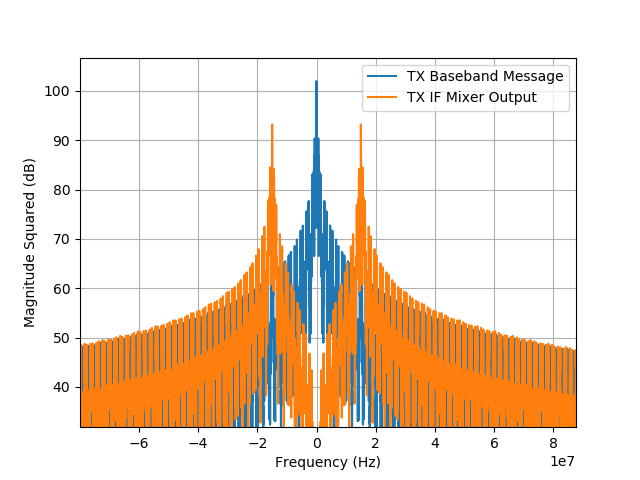

In [22]:
K=2**18
Msg = np.square(np.abs(np.fft.fft(msg,K)))
Si = np.square(np.abs(np.fft.fft(si,K)))
plt.plot(np.arange(-fs/2,fs/2,fs/K),10*np.log10(np.fft.fftshift(Msg)),'-',label="TX Baseband Message")
plt.plot(np.arange(-fs/2,fs/2,fs/K),10*np.log10(np.fft.fftshift(Si)),'-',label="TX IF Mixer Output")
plt.grid()
plt.ylabel("Magnitude Squared (dB)")
plt.xlabel("Frequency (Hz)")
plt.legend()
plt.show()

Heterodyne Mixing

In [23]:
sc=si*np.cos(2*np.pi*((fc-fi)/fs)*n) # subheterodyne carrier mixing

Image Reject Filtering

In [24]:
# Note: Butterworth filter frequency normalizations are relative to Nyquist, i.e., fs/2
numc, denc = butter(4,[(fc-B)/(fs/2),(fc+B)/(fs/2)],'bandpass',output='ba')
sf = 2*lfilter(numc,denc,sc)

Spectrum Plot of at RF

<IPython.core.display.Javascript object>


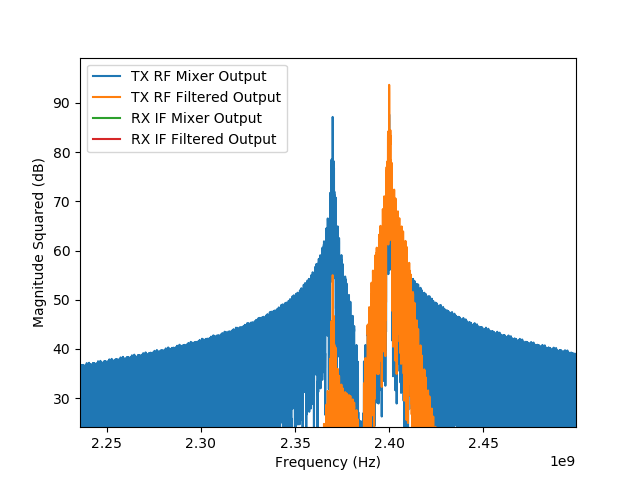

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


In [25]:
K=2**18
Sc = np.square(np.abs(np.fft.fft(sc,K)))
Sf = np.square(np.abs(np.fft.fft(sf,K)))
plt.plot(np.arange(-fs/2,fs/2,fs/K),10*np.log10(np.fft.fftshift(Sc)),'-',label="TX RF Mixer Output")
plt.plot(np.arange(-fs/2,fs/2,fs/K),10*np.log10(np.fft.fftshift(Sf)),'-',label="TX RF Filtered Output")
plt.grid()
plt.ylabel("Magnitude Squared (dB)")
plt.xlabel("Frequency (Hz)")
plt.legend()
plt.show()

RF to IF Downconversion

In [29]:
sfh = sf
sih = sfh*np.cos(2*np.pi*((fc-fi)/fs)*n)
# Note: Butterworth filter frequency normalizations are relative to Nyquist, i.e., fs/2
numi, deni = butter(2,(fi+B)/(fs/2),'lowpass',output='ba')
sihf = 2*lfilter(numi,deni,sih)

Rx IF Spectrum Plot

<IPython.core.display.Javascript object>


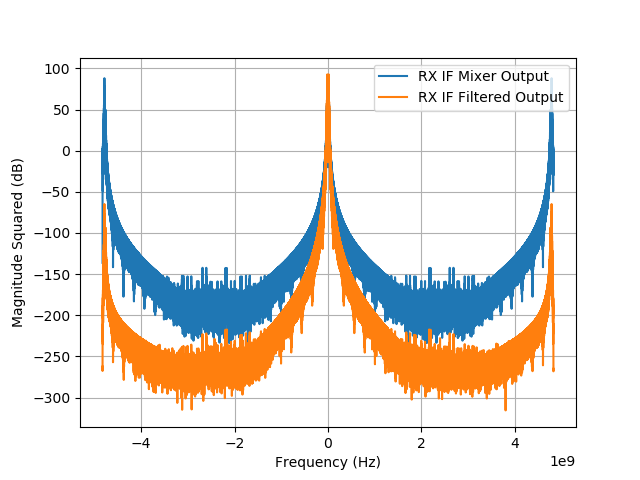

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


In [30]:
K=2**18
Sih = np.square(np.abs(np.fft.fft(sih,K)))
Sihf = np.square(np.abs(np.fft.fft(sihf,K)))
plt.plot(np.arange(-fs/2,fs/2,fs/K),10*np.log10(np.fft.fftshift(Sih)),'-',label="RX IF Mixer Output")
plt.plot(np.arange(-fs/2,fs/2,fs/K),10*np.log10(np.fft.fftshift(Sihf)),'-',label="RX IF Filtered Output")
plt.grid()
plt.ylabel("Magnitude Squared (dB)")
plt.xlabel("Frequency (Hz)")
plt.legend()
plt.show()

IF to BB Downconversion

In [31]:
sbh = sihf*np.cos(2*np.pi*(fi/fs)*n)
# Note: Butterworth filter frequency normalizations are relative to Nyquist, i.e., fs/2
numb, denb = butter(4,B/(fs/2),'lowpass',output='ba')
msgh = 2*lfilter(numb,denb,sbh)

Comparison Spectrum Plot

<IPython.core.display.Javascript object>


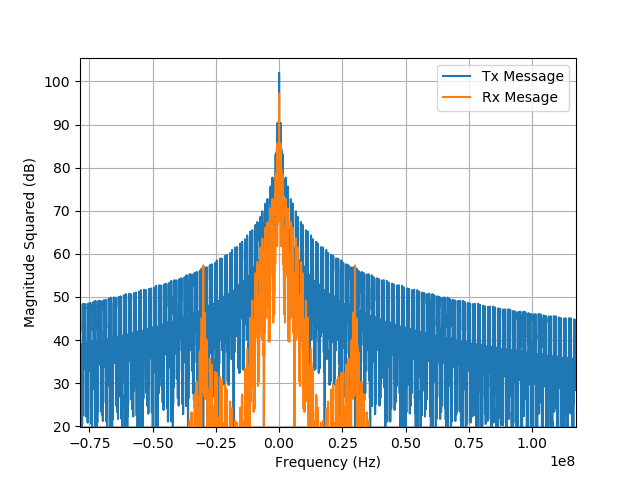

In [32]:
K=2**18
Msg = np.square(np.abs(np.fft.fft(msg,K)))
Msgh = np.square(np.abs(np.fft.fft(msgh,K)))
plt.plot(np.arange(-fs/2,fs/2,fs/K),10*np.log10(np.fft.fftshift(Msg)),'-',label="Tx Message")
plt.plot(np.arange(-fs/2,fs/2,fs/K),10*np.log10(np.fft.fftshift(Msgh)),'-',label="Rx Mesage")
plt.grid()
plt.ylabel("Magnitude Squared (dB)")
plt.xlabel("Frequency (Hz)")
plt.legend()
plt.show()

Comparison Time Domain Plot

<IPython.core.display.Javascript object>


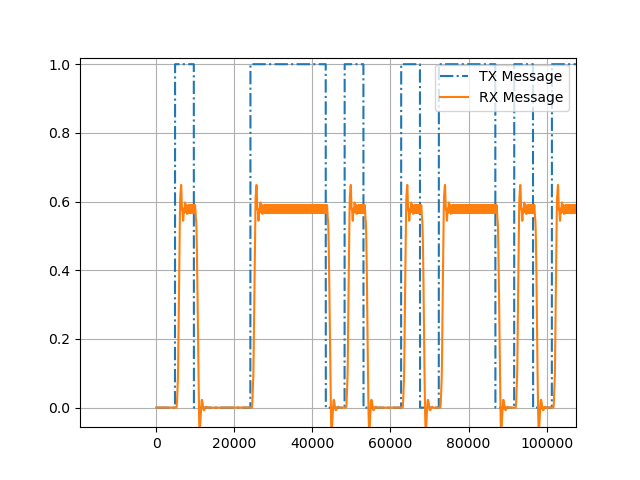

In [33]:
plt.plot(n,msg,'-.',label='TX Message')
plt.plot(n,msgh,'-',label='RX Message')
plt.legend()
plt.grid()
plt.show()

## Caveat

The numerical explorations in this lecture have treated the mixers as ideal, ignoring possible leakage and self-mixing issues. These should be explored futher for a complete design.